In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt 
from sklearn.linear_model import Ridge

from numpy import arange


### Data read

In [2]:
data=pd.read_csv('Dataset.data', sep=" ",header=None)
data.columns=["sex","length","diameter","height","whole_weight","shucked_weight","viscera_weight","shell_weight","rings"]

In [3]:
print(data.head())
print("Number of rows",len(data))


  sex  length  diameter  height  whole_weight  shucked_weight  viscera_weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   shell_weight  rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  
Number of rows 4177


### Data Preprocessing

In [4]:
data.isnull().values.any() ##check for null values

False

In [5]:
###one hot encoding for sex (different types dehklenge)
sex=pd.get_dummies(data.sex,prefix="sex")
onehot_data=data.drop(columns="sex")
onehot_data=pd.concat([sex,onehot_data],axis=1)
onehot_data = onehot_data.astype(float)

onehot_data.head()


,sex_F,sex_I,sex_M,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,0.0,0.0,1.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15.0
1,0.0,0.0,1.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7.0
2,1.0,0.0,0.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9.0
3,0.0,0.0,1.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10.0
4,0.0,1.0,0.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7.0


In [6]:
##Normalisation ((x-xmin)/xmax-xmin)
Normalised=pd.DataFrame()
for i in onehot_data.columns[:-1]:
    Normalised[i]=(onehot_data[i]-onehot_data[i].mean())/onehot_data[i].std()
Normalised["rings"]=onehot_data["rings"]
Normalised.head()

,sex_F,sex_I,sex_M,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,-0.674753,-0.687936,1.316520,-0.574489,-0.432097,-1.064297,-0.641821,-0.607613,-0.726125,-0.638140,15.0
1,-0.674753,-0.687936,1.316520,-1.448812,-1.439757,-1.183837,-1.230130,-1.170770,-1.205077,-1.212842,7.0
2,1.481669,-0.687936,-0.759397,0.050027,0.122116,-0.107978,-0.309432,-0.463444,-0.356647,-0.207114,9.0
3,-0.674753,-0.687936,1.316520,-0.699393,-0.432097,-0.347058,-0.637743,-0.648160,-0.607527,-0.602222,10.0
4,-0.674753,1.453277,-0.759397,-1.615350,-1.540523,-1.422916,-1.271933,-1.215822,-1.287183,-1.320599,7.0


In [7]:
#returns K folds of training and validation set
def create_cv(data,folds)->dict:
    di={}
    di_numpy={}
    size_of_folds=len(data)//folds
    for i in range(5):
        training=pd.concat([data[0:i*size_of_folds],data[(i+1)*size_of_folds:]],ignore_index=True,axis=0)
        validation=data[i*size_of_folds:(i+1)*size_of_folds].copy().reset_index(drop=True)
        di[i]={"training":training,"validation":validation}
        di_numpy[i]={"training":training.to_numpy(),"validation":validation.to_numpy()}
    return di_numpy,di
        
    

In [8]:
##Random shuffle 
Shuffled = Normalised.sample(frac=1,random_state=1).reset_index(drop=True)
Shuffled.head()


,sex_F,sex_I,sex_M,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,1.481669,-0.687936,-0.759397,-0.699393,-0.684012,-0.944757,-0.770291,-0.772054,-0.853845,-0.781816,10.0
1,-0.674753,-0.687936,1.316520,0.341468,0.273265,0.250642,0.328837,0.991753,0.017392,-0.235849,8.0
2,-0.674753,-0.687936,1.316520,-1.282275,-1.288608,-0.825217,-1.212797,-1.211317,-1.113848,-1.176923,9.0
3,-0.674753,-0.687936,1.316520,0.466371,0.474797,-0.107978,-0.067787,0.205586,-0.124013,-0.250217,10.0
4,1.481669,-0.687936,-0.759397,0.008393,-0.180182,-0.107978,-0.465431,-0.598602,-0.452438,-0.207114,16.0


In [9]:
###K Folds created as numpy arrays
No_of_folds=5
K_folds,k_folds_pandas=create_cv(Shuffled,No_of_folds)
p=len(K_folds[0]["training"][0])
K_folds[0]["training"].shape #(m x p)

(3342, 11)

### Gradient Descent

In [11]:
def cost(x,theta,b,y):
    m=len(x)
    yhat=np.dot(x,theta)+b
    return np.power(np.sum(np.power((yhat-y),2))/(m),0.5)

In [12]:
def gradients(x,theta,b,y):
    
    m=len(x)
    yhat=(np.dot(x,theta)+b)
    yhat=yhat.reshape(m,1)
    
    dtheta=np.dot(x.T,(yhat-y))/np.power(np.sum(np.power((yhat-y),2))*m,0.5)
    dtheta=dtheta.reshape(theta.shape)
    
    db=np.sum((yhat-y))/np.power(np.sum(np.power((yhat-y),2))*m,0.5)
    return db,dtheta


In [13]:
def runner(train_x,train_y,CV_x,CV_y,theta,b,learning_rate=0.0005,epochs=50):
    train_RMSE=np.zeros(epochs)
    CV_RMSE=np.zeros(epochs)
    for i in range(epochs):
        
        train_RMSE[i]=cost(train_x,theta,b,train_y)
        CV_RMSE[i]=cost(CV_x,theta,b,CV_y)
        
        db,dtheta=gradients(train_x,theta,b,train_y)
        
        theta=theta-learning_rate*dtheta
        b=b-learning_rate*(db)
      
    return [train_RMSE,CV_RMSE]

    

In [14]:
epochs=10000
learning_rate=0.005
train_RMSE=np.zeros(epochs)
CV_RMSE=np.zeros(epochs)
RMSE_folds={}
for i in range(No_of_folds):
    
    Theta=np.zeros(shape=(p-1,1)) #(p x 1)
    b=0
    
    train_x=np.copy(K_folds[i]["training"][:,:-1])
    train_y=np.copy(K_folds[i]["training"][:,-1]).reshape(-1,1)
    
    CV_x=np.copy(K_folds[i]["validation"][:,:-1])
    CV_y=np.copy(K_folds[i]["validation"][:,-1]).reshape(-1,1)


    RMSE=runner(train_x,train_y,CV_x,CV_y,Theta,b,learning_rate,epochs)
    
    RMSE_folds[i]={}
    RMSE_folds[i]["GD"]={}
    RMSE_folds[i]["GD"]["Training"]=RMSE[0][-1]
    RMSE_folds[i]["GD"]["CV"]=RMSE[1][-1]
    
    train_RMSE+=RMSE[0]
    CV_RMSE+=RMSE[1]

train_RMSE/=No_of_folds
CV_RMSE/=No_of_folds



    

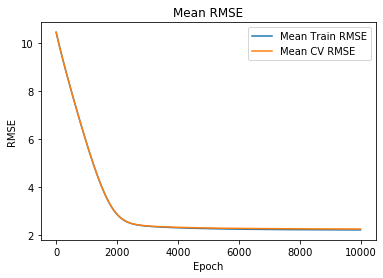

<Figure size 3600x3600 with 0 Axes>

In [15]:
####Training RMSE plot####
x_axis=list(range(1,epochs+1))
y_axis=train_RMSE
plt.plot(x_axis, y_axis,label="Mean Train RMSE") 


####CV RMSE plot####
x_axis=list(range(1,epochs+1))
y_axis=CV_RMSE
plt.plot(x_axis, y_axis,label="Mean CV RMSE") 
  

plt.xlabel('Epoch')  
plt.ylabel('RMSE') 
plt.title('Mean RMSE') 

plt.legend()
plt.figure(figsize=(50, 50))

plt.show() 

### Normal Equation

In [16]:
normal_data=Shuffled.copy().to_numpy()
normal_x=np.concatenate((np.ones((len(normal_data),1)), normal_data[:,:-1]), axis=1)

normal_y=normal_data[:,-1].reshape(-1,1)
normal_theta=np.dot(np.linalg.pinv(normal_x),normal_y)

In [17]:
cost(normal_x,normal_theta,0,normal_y)

2.1914982239741514

In [18]:
RMSE_folds

{0: {'GD': {'Training': 2.2293466284282846, 'CV': 2.2217013976421334}},
 1: {'GD': {'Training': 2.2100653612250794, 'CV': 2.4294988637127015}},
 2: {'GD': {'Training': 2.22575917196637, 'CV': 2.2479439878835867}},
 3: {'GD': {'Training': 2.2123043665307573, 'CV': 2.285771437849997}},
 4: {'GD': {'Training': 2.2544252297181884, 'CV': 2.1335499733770145}}}

In [19]:
for i in range(No_of_folds):
    
    
    train_x=np.concatenate((np.ones((len(K_folds[i]["training"]),1)), np.copy(K_folds[i]["training"][:,:-1])), axis=1)
    train_y=np.copy(K_folds[i]["training"][:,-1]).reshape(-1,1)
    
    CV_x=np.concatenate((np.ones((len(K_folds[i]["validation"]),1)), np.copy(K_folds[i]["validation"][:,:-1])), axis=1)
    CV_y=np.copy(K_folds[i]["validation"][:,-1]).reshape(-1,1)


    
    
    RMSE_folds[i]["Normal"]={}
    RMSE_folds[i]["Normal"]["Training"]=cost(train_x,normal_theta,0,train_y)
    RMSE_folds[i]["Normal"]["CV"]=cost(CV_x,normal_theta,0,CV_y)

In [20]:
RMSE_folds

{0: {'GD': {'Training': 2.2293466284282846, 'CV': 2.2217013976421334},
  'Normal': {'Training': 2.1947405106875544, 'CV': 2.1784730037480684}},
 1: {'GD': {'Training': 2.2100653612250794, 'CV': 2.4294988637127015},
  'Normal': {'Training': 2.1815244863900927, 'CV': 2.2309707433109525}},
 2: {'GD': {'Training': 2.22575917196637, 'CV': 2.2479439878835867},
  'Normal': {'Training': 2.1891504546243876, 'CV': 2.2008698531759774}},
 3: {'GD': {'Training': 2.2123043665307573, 'CV': 2.285771437849997},
  'Normal': {'Training': 2.172928712784352, 'CV': 2.264296730876372}},
 4: {'GD': {'Training': 2.2544252297181884, 'CV': 2.1335499733770145},
  'Normal': {'Training': 2.218728761655651, 'CV': 2.078943339696214}}}

### Regularization

In [21]:
#### TO Find the CV set with the least RMSE
pos=-1
m1=100000
for i in RMSE_folds:
    if m1> RMSE_folds[i]["GD"]["CV"]:
        pos=i
        m1=RMSE_folds[i]["GD"]["CV"]

In [22]:
####New Data #y (m x 1) x=m x p px1
Train_CV_Data=k_folds_pandas[pos]["training"]
Test_Data=k_folds_pandas[pos]["validation"]


In [23]:
clf = Ridge(alpha=0.005)
clf.fit(Train_CV_Data.to_numpy()[:,:-1],(Train_CV_Data.to_numpy()[:,-1]).reshape(-1,1))
d=clf.score(Train_CV_Data.to_numpy()[:,:-1],(Train_CV_Data.to_numpy()[:,-1]).reshape(-1,1))
print(d)

0.5331370035596337


In [24]:
### Shuffle data
Train_CV_Data = Train_CV_Data.sample(frac=1,random_state=1).reset_index(drop=True)

regular_kfolds,regular_kfolds_pandas=create_cv(Train_CV_Data,No_of_folds)


### Grid Search 

In [25]:
len(regular_kfolds[0]["training"])

2674

In [26]:
#### Grid Search for L1 regularization
L1_values=arange(0.000001,0.00001,0.000001)
min_value=-1
min_RMSE=0
epochs=10000
learning_rate=0.005
for j in L1_values:
    print(j)
    RMSE=0
    for i in range(No_of_folds):
    
        ####initialise thetas#### 
        Theta=np.zeros(shape=(p-1,1)) #(p x 1)
        b=0

        train_x=np.copy(regular_kfolds[i]["training"][:,:-1])
        train_y=np.copy(regular_kfolds[i]["training"][:,-1]).reshape(-1,1)
        CV_x=np.copy(regular_kfolds[i]["validation"][:,:-1])
        CV_y=np.copy(regular_kfolds[i]["validation"][:,-1]).reshape(-1,1)



        temp=runner_reg(train_x,train_y,CV_x,CV_y,Theta,b,learning_rate,epochs,j,"l1")
        RMSE+=temp[0][-1]
    RMSE/=No_of_folds
    if min_value==-1:
        min_RMSE=RMSE
        min_value=j
        
    elif min_RMSE>RMSE:
        min_RMSE=RMSE
        min_value=j
    else:
        break
print(min_RMSE,min_value)
        
        
    

1e-06


NameError: name 'runner_reg' is not defined

In [70]:
def cost_reg(x,theta,b,y,reg_para,regular_type):
    m=len(x)
    yhat=np.dot(x,theta)+b
    if regular_type=="l1":
        return np.power(np.sum(np.power((yhat-y),2))/(m),0.5)+(reg_para*np.sum(np.abs(theta)))/m
    elif regular_type=="l2":
        return np.power(np.sum(np.power((yhat-y),2))/(m),0.5)+(reg_para*np.sum((theta**2)))/m
        


In [71]:
def gradients_reg(x,theta,b,y,reg_para,regular_type):
    
    m=len(x)
    yhat=(np.dot(x,theta)+b)
    yhat=yhat.reshape(m,1)
        
        
    if regular_type=="l1":
        if np.count_nonzero(theta)!=0:
            dtheta=np.dot(x.T,(yhat-y))/np.power(np.sum(np.power((yhat-y),2))*m,0.5)+(reg_para*(theta/np.abs(theta)))/m
        else:
            dtheta=np.dot(x.T,(yhat-y))/np.power(np.sum(np.power((yhat-y),2))*m,0.5)

    elif regular_type=="l2":
        dtheta=np.dot(x.T,(yhat-y))/np.power(np.sum(np.power((yhat-y),2))*m,0.5)+(2*reg_para*(theta))/m

        
    dtheta=dtheta.reshape(theta.shape)
    
    db=np.sum((yhat-y))/np.power(np.sum(np.power((yhat-y),2))*m,0.5)
    return db,dtheta

In [29]:
def runner_reg(train_x,train_y,CV_x,CV_y,theta,b,learning_rate=0.0005,epochs=50,reg_para=1,regular_type="l1"):
    train_RMSE=np.zeros(epochs)
    CV_RMSE=np.zeros(epochs)
    for i in range(epochs):
        
        train_RMSE[i]=cost_reg(train_x,theta,b,train_y,reg_para,regular_type)
        CV_RMSE[i]=cost_reg(CV_x,theta,b,CV_y,reg_para,regular_type)
        
        db,dtheta=gradients_reg(train_x,theta,b,train_y,reg_para,regular_type)
        
        theta=theta-learning_rate*dtheta
        b=b-learning_rate*(db)
        
    return [train_RMSE,CV_RMSE]

In [30]:
epochs=10000
learning_rate=0.005
train_RMSE=np.zeros(epochs)
CV_RMSE=np.zeros(epochs)
RMSE_folds={}

for i in range(No_of_folds):
    
    ####initialise thetas#### 
    Theta=np.zeros(shape=(p-1,1)) #(p x 1)
    b=0
    
    train_x=np.copy(regular_kfolds[i]["training"][:,:-1])
    train_y=np.copy(regular_kfolds[i]["training"][:,-1]).reshape(-1,1)
    
    CV_x=np.copy(regular_kfolds[i]["validation"][:,:-1])
    CV_y=np.copy(regular_kfolds[i]["validation"][:,-1]).reshape(-1,1)


    RMSE=runner_reg(train_x,train_y,CV_x,CV_y,Theta,b,learning_rate,epochs,0.000001,"l2")
    
    RMSE_folds[i]={}
    RMSE_folds[i]["GD"]={}
    RMSE_folds[i]["GD"]["Training"]=RMSE[0][-1]
    RMSE_folds[i]["GD"]["CV"]=RMSE[1][-1]
    
    train_RMSE+=RMSE[0]
    CV_RMSE+=RMSE[1]

train_RMSE/=No_of_folds
CV_RMSE/=No_of_folds

In [31]:
RMSE_folds

{0: {'GD': {'Training': 2.2625450752130436, 'CV': 2.2231475117315873}},
 1: {'GD': {'Training': 2.253440122819618, 'CV': 2.2596573901047607}},
 2: {'GD': {'Training': 2.2665479357052707, 'CV': 2.1954267113813306}},
 3: {'GD': {'Training': 2.241786052985603, 'CV': 2.4730130936600796}},
 4: {'GD': {'Training': 2.231653348659265, 'CV': 2.3421566987496854}}}

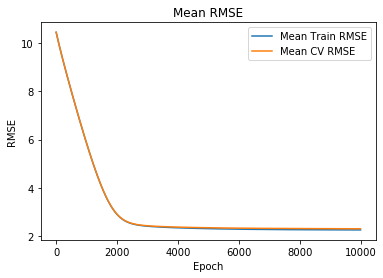

<Figure size 3600x3600 with 0 Axes>

In [32]:
####Training RMSE plot####
x_axis=list(range(1,epochs+1))
y_axis=train_RMSE
plt.plot(x_axis, y_axis,label="Mean Train RMSE") 


####CV RMSE plot####
x_axis=list(range(1,epochs+1))
y_axis=CV_RMSE
plt.plot(x_axis, y_axis,label="Mean CV RMSE") 
  

plt.xlabel('Epoch')  
plt.ylabel('RMSE') 
plt.title('Mean RMSE') 

plt.legend()
plt.figure(figsize=(50, 50))

plt.show() 

In [ ]:
RMSE_folds

In [36]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
# load the dataset
dataframe = Shuffled
data = dataframe.values
X, y = data[:, :-1], data[:, -1]
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
model = LassoCV(alphas=arange(0.00000001, 0.0000001, 0.00000001), cv=cv)
# fit model
model.fit(X, y)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)


/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1935.284905389617, tolerance: 3.843914498536844
  model = cd_fast.enet_coordinate_descent_gram(
/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 642.3143724213332, tolerance: 3.843914498536844
  model = cd_fast.enet_coordinate_descent_gram(
/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 642.3127079081041, tolerance: 3.843914498536844
  model = cd_fast.enet_coordinate_descent_gram(
/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descen

/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615.4883740774694, tolerance: 3.836734441489362
  model = cd_fast.enet_coordinate_descent_gram(
/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615.4933478030107, tolerance: 3.836734441489362
  model = cd_fast.enet_coordinate_descent_gram(
/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2595.2277847492624, tolerance: 3.9427532322426204
  model = cd_fast.enet_coordinate_descent_gram(
/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 653.5350920904912, tolerance: 3.9859380686352766
  model = cd_fast.enet_coordinate_descent_gram(
/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 653.5337394963244, tolerance: 3.9859380686352766
  model = cd_fast.enet_coordinate_descent_gram(
/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 653.5372535015631, tolerance: 3.9859380686352766
  model = cd_fast.enet_coordinate_descent_gram(
/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_des

/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 647.689971357353, tolerance: 3.878912104283053
  model = cd_fast.enet_coordinate_descent_gram(
/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 647.6902055394166, tolerance: 3.878912104283053
  model = cd_fast.enet_coordinate_descent_gram(
/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 647.690336401607, tolerance: 3.878912104283053
  model = cd_fast.enet_coordinate_descent_gram(
/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.

alpha: 0.000000


/home/blah/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1760.4536777491394, tolerance: 4.341063059612137
  model = cd_fast.enet_coordinate_descent(


### Q3

In [21]:
data=pd.read_csv("data.csv")

In [22]:
data.head()

,Brain_Weight,Body_Weight
0,1.0,8.429338
1,1.6,10.516225
2,2.2,12.339744
3,2.8,19.217969
4,3.4,19.749753


In [34]:
train_X=data.to_numpy()[:,0].reshape((-1,1))
train_Y=data.to_numpy()[:,1].reshape((-1,1))

In [56]:
def runner_q3(train_x,train_y,theta,b,learning_rate=0.0005,epochs=50):
    train_RMSE=np.zeros(epochs)
    for i in range(epochs):
        
        train_RMSE[i]=cost(train_x,theta,b,train_y)
        
        db,dtheta=gradients(train_x,theta,b,train_y)
        
        theta=theta-learning_rate*dtheta
        b=b-learning_rate*(db)
        
    return [theta[0,0],b]

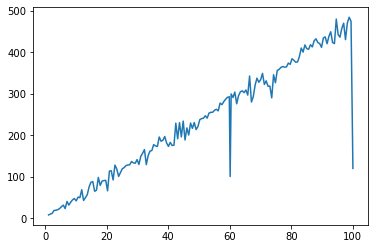

In [57]:
plt.plot(train_X,train_Y)

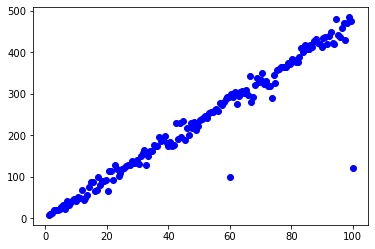

In [58]:



plt.scatter(train_X,train_Y, c ="blue")
  
# To show the plot
plt.show()

In [59]:
p=1
Theta=np.zeros((p,1)) #(p x 1)
b=0
theta=runner_q3(train_X,train_Y,Theta,0,epochs=100000)
print(theta)

[4.614621577730783, 1.532642485662522]


In [60]:
x_line=[]
y_line=[]
for i in range(0,100):
    x_line.append(i)
    y_line.append(i*theta[0]+theta[1])
print()

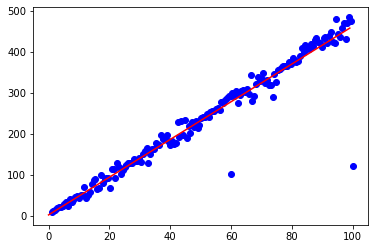

In [63]:
plt.scatter(train_X,train_Y, c ="blue")
plt.plot(x_line,y_line,'r')
# To show the plot
plt.show()

In [66]:
def runner_q3_reg(train_x,train_y,theta,b,reg_para,regular_type,learning_rate=0.0005,epochs=50):
    for i in range(epochs):
        
        
        db,dtheta=gradients_reg(train_x,theta,b,train_y,reg_para,regular_type)
        
        theta=theta-learning_rate*dtheta
        b=b-learning_rate*(db)
        
    return [theta[0,0],b]

[4.562401221597937, 3.246573092278306]



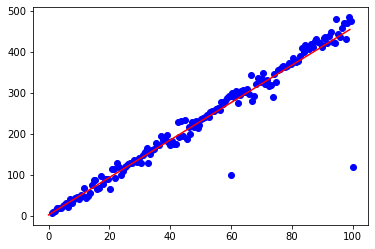

In [79]:
p=1
Theta=np.zeros((p,1)) #(p x 1)
b=0
theta=runner_q3_reg(train_X,train_Y,Theta,0,50,"l2",epochs=100000)
print(theta)

x_line=[]
y_line=[]
for i in range(0,100):
    x_line.append(i)
    y_line.append(i*theta[0]+theta[1])
print()
plt.scatter(train_X,train_Y, c ="blue")
plt.plot(x_line,y_line,'r')

# To show the plot
plt.show()

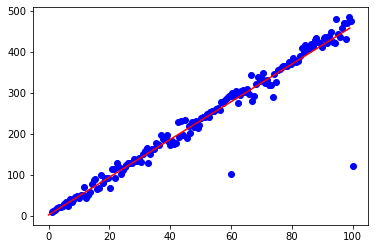

In [73]:
plt.scatter(train_X,train_Y, c ="blue")
plt.plot(x_line,y_line,'r')

# To show the plot
plt.show()

[4.511095981376977, 4.928879065602582]



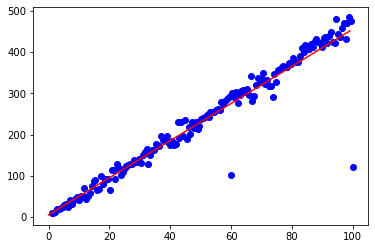

In [77]:
p=1
Theta=np.zeros((p,1)) #(p x 1)
b=0
theta=runner_q3_reg(train_X,train_Y,Theta,0,100,"l2",epochs=100000)
print(theta)

x_line=[]
y_line=[]
for i in range(0,100):
    x_line.append(i)
    y_line.append(i*theta[0]+theta[1])
print()

plt.scatter(train_X,train_Y, c ="blue")
plt.plot(x_line,y_line,'r')

# To show the plot
plt.show()